# ML: Breast Cancer 

## Strategy

- Data split:
    - Data is split into **train (90%)** and **test (10%)**
    - Train data is used for cross-validation as well when performing hyperparameter tuning 
- Encoding:
    - y data: **LabelEncoder**
    - x data: **TargetEncoder**
- Null/empty values:
    - Used **SimpleImputer**:
        - numerical columns: **mean**
        - categorical columns: **most_frequent**
- Feature selection:
    - Used **RandomForestClassifier** and **SelectFromModel** to select the needed features 
    - Removed features from x_train data
- Model training:
    - Used **XGBClassifier** as it was stated in multiple papers for yielding the best results 
    - Used **f1_macro** for scoring 
    - Fit using **train** data
- Testing:
    - Pre-processing applied:
        - Encode the test data 
        - Handle null/empty values similar to the handling of the train data
        - Remove feature from **x_test** similar to the ones removed from the **x_train**
    - Generate predictions
    - Display the following metrics:
        - Accuracy 
        - Precision 
        - Recall 
        - F1 Score 

## Imports

In [1]:
!pip install category_encoders
!pip install xgboost

In [21]:
import numpy as np
import pandas as pd
import sklearn
import pickle
import category_encoders as ce
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.model_selection import learning_curve


## Save

In [22]:
def save(fileName, item):
  with open(fileName, 'wb') as f:
      pickle.dump(item, f)

## Load and Split the Data

In [23]:
data = pd.read_csv("data.csv", encoding="utf-8")

y = data["cancer_type"]
x = data.drop(columns = ["cancer_type", "patient_id"])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, shuffle=True, random_state=3)

C:\Users\aidaf\AppData\Local\Temp\ipykernel_15380\2955086971.py:1: DtypeWarning: Columns (662,664,676,677,683,685,686,687) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("data.csv", encoding="utf-8")


## Training

In [24]:
def get_categorical_columns(df):
    return list(df.select_dtypes(include=['object', 'category']).columns)
def get_numerical_columns(df):
    return list(df.select_dtypes(include=['number']).columns)

In [25]:
categorical_columns = get_categorical_columns(x_train)
numerical_columns = get_numerical_columns(x_train)

### Encode x_train and y_train

In [26]:
y_train = LabelEncoder().fit_transform(y_train)

encoder = ce.TargetEncoder(cols=categorical_columns)
x_train = encoder.fit_transform(x_train, y_train)

### Fill Null/Empty Values

In [27]:
numerical_imputer = SimpleImputer(strategy='mean') 
categorical_imputer = SimpleImputer(strategy='most_frequent')  

In [28]:
if numerical_columns:
    x_train[numerical_columns] = numerical_imputer.fit_transform(x_train[numerical_columns])

if categorical_columns:
    x_train[categorical_columns] = categorical_imputer.fit_transform(x_train[categorical_columns])

### Apply Feature Selection 

In [29]:
rf_classifier = RandomForestClassifier(n_estimators=50, random_state=42)
pipeline = Pipeline([
    ('feature_selection', SelectFromModel(rf_classifier)),
    ('classification', rf_classifier)
])

param_grid = {'feature_selection__threshold': ['mean', 'median', '1.25*mean']}

grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(x_train, y_train)

best_pipeline = grid_search.best_estimator_

print("Selected Features Threshold:", best_pipeline.named_steps['feature_selection'].threshold)

feature_importances = best_pipeline.named_steps['classification'].feature_importances_
selected_features_mask = best_pipeline.named_steps['feature_selection'].get_support()
x_train = x_train.iloc[:, selected_features_mask]

save('Common/selected_features_mask.pkl', selected_features_mask)

Selected Features Threshold: 1.25*mean


### Plot Feature Importance

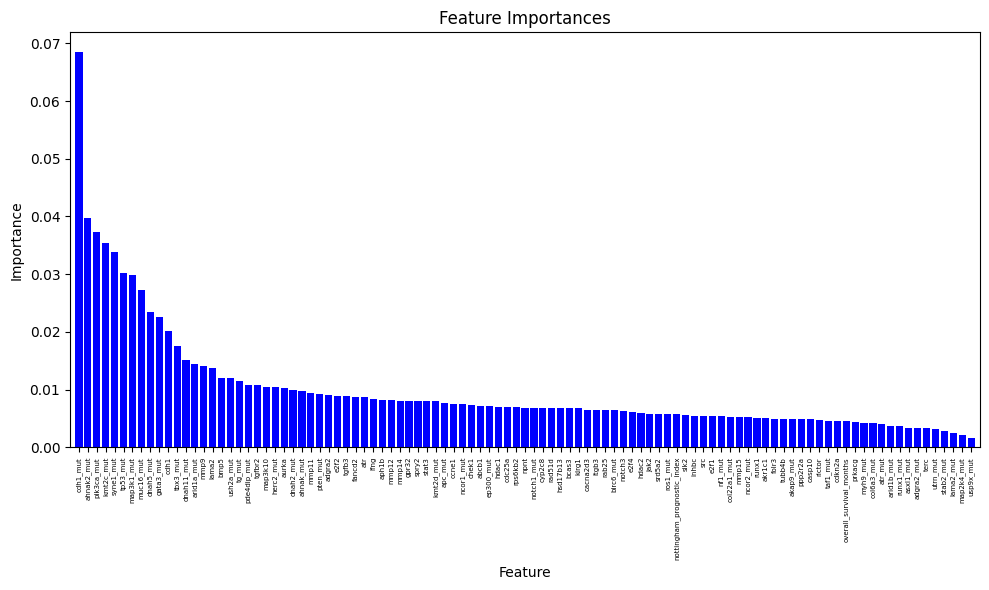

In [30]:
indices = feature_importances.argsort()[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(x_train.shape[1]), feature_importances[indices], align="center", color="blue")
plt.xticks(range(x_train.shape[1]), x_train.columns[indices], rotation=90, fontsize=5)
plt.xlim([-1, x_train.shape[1]])
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

### XGBoost Model Training

In [31]:
param_grid = {
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.3],
    'n_estimators': [100, 200, 300],
}

xgb_model = XGBClassifier()
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='f1_macro')
grid_search.fit(x_train, y_train)

best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

best_score = grid_search.best_score_
print("Best Cross-Validation Score:", best_score)

best_model = grid_search.best_estimator_
print("Best Model:", best_model)

save('Common/best_model.pkl', best_model)

Best Hyperparameters: {'learning_rate': 0.01, 'max_depth': 9, 'n_estimators': 100}
Best Cross-Validation Score: 0.5973969939286212
Best Model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)


c:\Users\aidaf\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:542: FitFailedWarning: 
7 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
7 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\aidaf\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\aidaf\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py", line 730, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\aidaf\AppData\Local\Programs\Python\Python312\Lib\site-packages

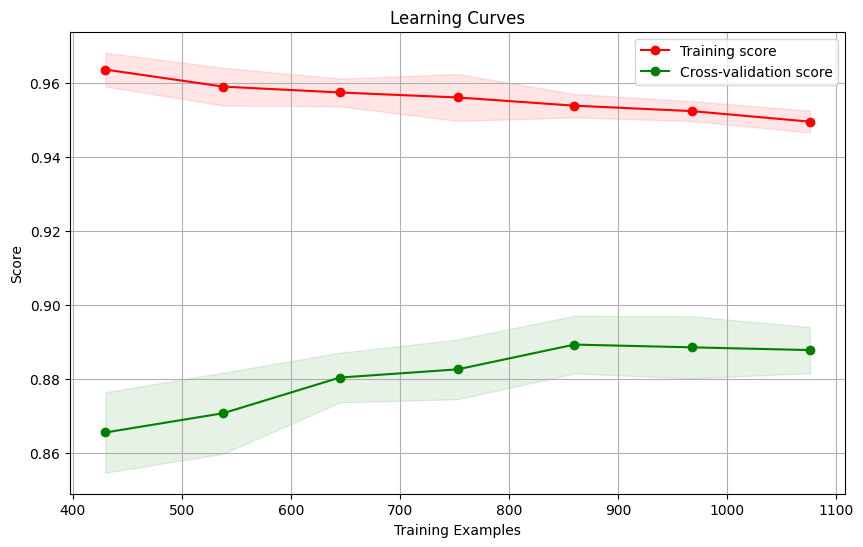

In [13]:
def plot_learning_curves(model, x_train, y_train):
    train_sizes, train_scores, val_scores = learning_curve(model, x_train, y_train, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10))

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    val_scores_mean = np.mean(val_scores, axis=1)
    val_scores_std = np.std(val_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.title("Learning Curves")
    plt.xlabel("Training Examples")
    plt.ylabel("Score")
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, val_scores_mean - val_scores_std, val_scores_mean + val_scores_std, alpha=0.1, color="g")

    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, val_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    plt.show()

plot_learning_curves(best_model, x_train, y_train)

## Testing

### Apply Encoding to Test Data

In [14]:
y_test = LabelEncoder().fit_transform(y_test)

encoder = ce.TargetEncoder(cols=categorical_columns)
x_test = encoder.fit_transform(x_test, y_test)

### Handle Null/Empty Values of Test Data

In [15]:
if numerical_columns:
    x_test[numerical_columns] = numerical_imputer.fit_transform(x_test[numerical_columns])

if categorical_columns:
    x_test[categorical_columns] = categorical_imputer.fit_transform(x_test[categorical_columns])

### Apply Feature Selection on Test Data

In [16]:
x_test = x_test.iloc[:, selected_features_mask]

### Test and Display Metrics 

In [17]:
test_pred = best_model.predict(x_test)

accuracy = accuracy_score(y_test, test_pred)
precision = precision_score(y_test, test_pred, average="macro")
recall = recall_score(y_test, test_pred, average="macro")
f1 = f1_score(y_test, test_pred, average="macro")

print("accuracy =", accuracy)
print("precision =", precision)
print("recall =", recall)
print("f1-score =", f1)

accuracy = 0.8733333333333333
precision = 0.8215053763440859
recall = 0.6321504237288136
f1-score = 0.6959704349986482
